In [1]:
import os
import sys
import time
import pickle

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import wandb

In [2]:
from torchmetrics import Accuracy

In [3]:
root_path = os.path.join(os.getcwd().split('cbo-in-tensorflow')[0], 'cbo-in-tensorflow')

sys.path.append(root_path)

In [4]:
from src.datasets import load_mnist_dataloaders
from src.torch.models import *
from src.torch import Optimizer, Loss

In [5]:
IMAGES_FOLDER = os.path.join(os.getcwd(), 'plots')

os.makedirs(IMAGES_FOLDER, exist_ok=True)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('gpu')

Let's compare model convergence with full and partial updates.

In [7]:
epochs = 25
batch_size = 60
particles_batch_size = 10

n_particles = 100
alpha = 50
sigma = 0.4 ** 0.5
l = 1
dt = 0.1
anisotropic = True
eps = 1e-2

partial_update = False

use_multiprocessing=False
n_processes = 4

In [8]:
train_dataloader, test_dataloader = load_mnist_dataloaders(train_batch_size=batch_size,
                                                           test_batch_size=batch_size)

In [9]:
n_batches = len(train_dataloader)

In [10]:
eval_freq = 100

In [11]:
def evaluate(model, X_, y_):
    with torch.no_grad():
        outputs = model(X_)
        y_pred = torch.argmax(outputs, dim=1)
        loss = loss_fn(outputs, y_)
        acc = accuracy(y_pred.cpu(), y_.cpu())
    return loss, acc

def log(loss, acc, epoch, stage='train', shift_norm=None):
    wandb.log({
        f'{stage}_loss': loss,
        f'{stage}_acc': acc,
        'epoch': epoch,
        f'{stage}_shift_norm': shift_norm,
    })

## SmallMLP

### Full update

In [73]:
model = SmallMLP().to(device)
optimizer = Optimizer(model, n_particles=n_particles, alpha=alpha, sigma=sigma,
                      l=l, dt=dt, anisotropic=anisotropic, eps=eps, partial_update=partial_update,
                      use_multiprocessing=use_multiprocessing, n_processes=n_processes,
                      particles_batch_size=particles_batch_size, device=device)
loss_fn = Loss(F.nll_loss, optimizer)
accuracy = Accuracy()

In [75]:
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

for epoch in range(epochs):
    epoch_train_accuracies = []
    epoch_train_losses = []
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        train_loss, train_acc = evaluate(model, X, y)
        epoch_train_accuracies.append(train_acc)
        epoch_train_losses.append(train_loss.cpu())
        
        optimizer.zero_grad()
        loss_fn.backward(X, y, backward_gradients=False)
        optimizer.step()
        
        if batch % eval_freq == 0 or batch == n_batches - 1:
            with torch.no_grad():
                losses = []
                accuracies = []
                for X_test, y_test in test_dataloader:
                    X_test, y_test = X_test.to(device), y_test.to(device)
                    loss, acc = evaluate(model, X_test, y_test)
                    losses.append(loss.cpu())
                    accuracies.append(acc.cpu())
                val_loss, val_acc = np.mean(losses), np.mean(accuracies)
                if batch == n_batches - 1:
                    val_accuracies.append(val_acc)
                    val_losses.append(val_loss)

            print(f'Epoch: {epoch + 1:2}/{epochs}, batch: {batch + 1:4}/{n_batches}, train loss: {train_loss:8.3f}, train acc: {train_acc:8.3f}, val loss: {val_loss:8.3f}, val acc: {val_acc:8.3f}',
                  end='\r')
    train_accuracies.append(np.mean(epoch_train_accuracies))
    train_losses.append(np.mean(epoch_train_losses))

In [76]:
with open('full_update.pkl', 'wb') as pkl_file:
    pickle.dump((train_accuracies, val_accuracies, train_losses, val_losses), pkl_file)

### Partial update

In [80]:
model = SmallMLP().to(device)
optimizer = Optimizer(model, n_particles=n_particles, alpha=alpha, sigma=sigma,
                      l=l, dt=dt, anisotropic=anisotropic, eps=eps, partial_update=True,
                      use_multiprocessing=use_multiprocessing, n_processes=n_processes,
                      particles_batch_size=particles_batch_size, device=device)
loss_fn = Loss(F.nll_loss, optimizer)

In [81]:
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

for epoch in range(epochs):
    epoch_train_accuracies = []
    epoch_train_losses = []
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        train_loss, train_acc = evaluate(model, X, y)
        epoch_train_accuracies.append(train_acc)
        epoch_train_losses.append(train_loss.cpu())
        
        optimizer.zero_grad()
        loss_fn.backward(X, y, backward_gradients=False)
        optimizer.step()
        
        if batch % eval_freq == 0 or batch == n_batches - 1:
            with torch.no_grad():
                losses = []
                accuracies = []
                for X_test, y_test in test_dataloader:
                    X_test, y_test = X_test.to(device), y_test.to(device)
                    loss, acc = evaluate(model, X_test, y_test)
                    losses.append(loss.cpu())
                    accuracies.append(acc.cpu())
                val_loss, val_acc = np.mean(losses), np.mean(accuracies)
                if batch == n_batches - 1:
                    val_accuracies.append(val_acc)
                    val_losses.append(val_loss)

            print(f'Epoch: {epoch + 1:2}/{epochs}, batch: {batch + 1:4}/{n_batches}, train loss: {train_loss:8.3f}, train acc: {train_acc:8.3f}, val loss: {val_loss:8.3f}, val acc: {val_acc:8.3f}',
                  end='\r')
    train_accuracies.append(np.mean(epoch_train_accuracies))
    train_losses.append(np.mean(epoch_train_losses))

In [82]:
with open('partial_update.pkl', 'wb') as pkl_file:
    pickle.dump((train_accuracies, val_accuracies, train_losses, val_losses), pkl_file)

### Evaluation

In [102]:
with open('full_update.pkl', 'rb') as pkl_file:
    full_train_acc, full_val_acc, full_train_loss, full_val_loss = pickle.load(pkl_file)
with open('partial_update.pkl', 'rb') as pkl_file:
    partial_train_acc, partial_val_acc, partial_train_loss, partial_val_loss = pickle.load(pkl_file)

In [103]:
epchs_range = np.arange(1, epochs + 1, dtype=int)

In [104]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 25

<Figure size 1440x720 with 0 Axes>

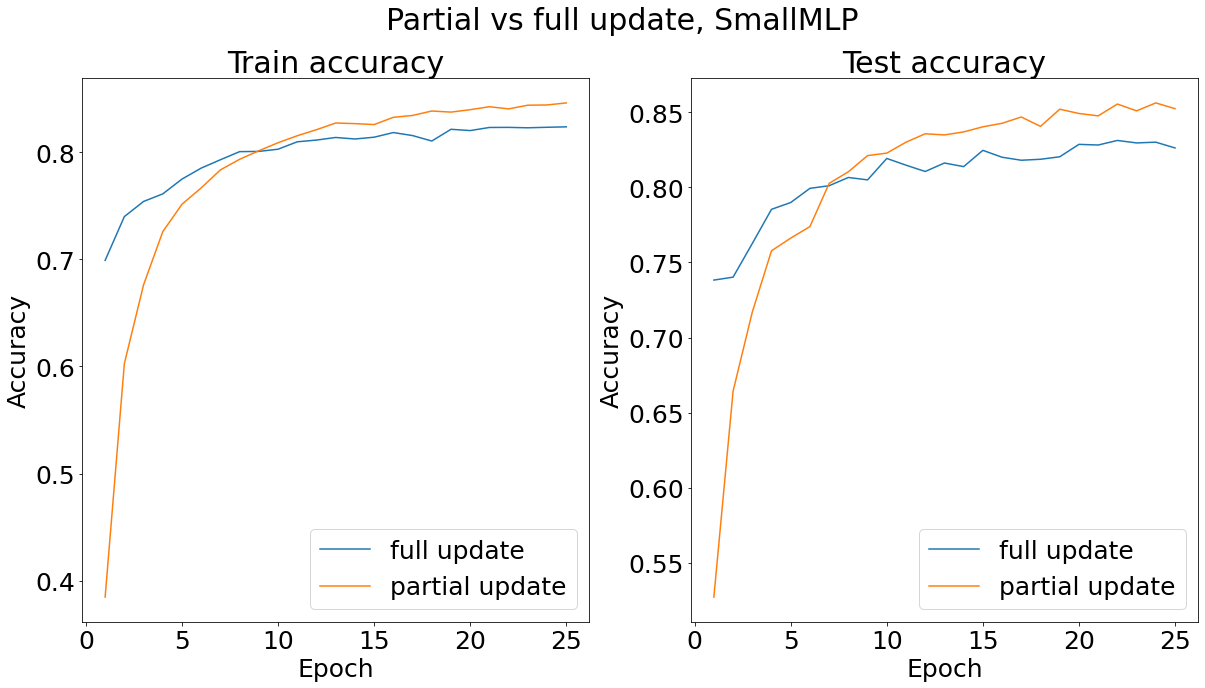

In [93]:
plt.clf()

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(epchs_range, full_train_acc, label='full update')
ax1.plot(epchs_range, partial_train_acc, label='partial update')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Train accuracy')

ax2.plot(epchs_range, full_val_acc, label='full update')
ax2.plot(epchs_range, partial_val_acc, label='partial update')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Test accuracy')

plt.suptitle('Partial vs full update, SmallMLP')

plt.savefig(os.path.join(IMAGES_FOLDER, 'partial_vs_full_small_mlp_acc.png'))

<Figure size 1440x720 with 0 Axes>

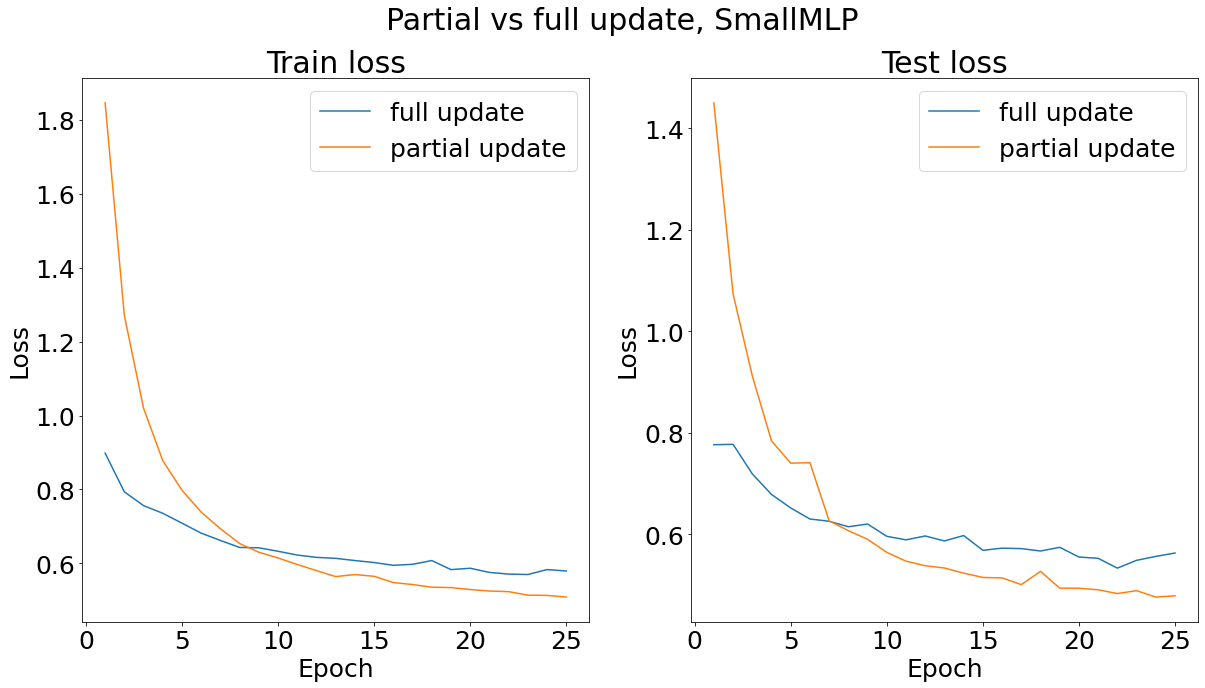

In [105]:
plt.clf()

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(epchs_range, full_train_loss, label='full update')
ax1.plot(epchs_range, partial_train_loss, label='partial update')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train loss')

ax2.plot(epchs_range, full_val_loss, label='full update')
ax2.plot(epchs_range, partial_val_loss, label='partial update')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Test loss')

plt.suptitle('Partial vs full update, SmallMLP')

plt.savefig(os.path.join(IMAGES_FOLDER, 'partial_vs_full_small_mlp_loss.png'))

## LeNet5

### Full update

In [12]:
eps = 4e-2

In [13]:
wandb.init(project='CBO', entity='itukh')

wandb: Currently logged in as: itukh. Use `wandb login --relogin` to force relogin


In [14]:
model = LeNet5().to(device)
optimizer = Optimizer(model, n_particles=n_particles, alpha=alpha, sigma=sigma,
                      l=l, dt=dt, anisotropic=anisotropic, eps=eps, partial_update=False,
                      use_multiprocessing=use_multiprocessing, n_processes=n_processes,
                      particles_batch_size=particles_batch_size, device=device)
loss_fn = Loss(F.nll_loss, optimizer)
accuracy = Accuracy()

In [15]:
val_accuracies = []
train_accuracies = []

for epoch in range(epochs):
    epoch_train_accuracies = []
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        train_loss, train_acc = evaluate(model, X, y)
        log(train_loss, train_acc, epoch, shift_norm=optimizer.shift_norm)
        epoch_train_accuracies.append(train_acc)
        
        optimizer.zero_grad()
        loss_fn.backward(X, y, backward_gradients=False)
        optimizer.step()
        
        if batch % eval_freq == 0 or batch == n_batches - 1:
            with torch.no_grad():
                losses = []
                accuracies = []
                for X_test, y_test in test_dataloader:
                    X_test, y_test = X_test.to(device), y_test.to(device)
                    loss, acc = evaluate(model, X_test, y_test)
                    losses.append(loss.cpu())
                    accuracies.append(acc.cpu())
                val_loss, val_acc = np.mean(losses), np.mean(accuracies)
                log(val_loss, val_acc, epoch, 'val')
                if batch == n_batches - 1:
                    val_accuracies.append((epoch, val_acc))

            print(f'Epoch: {epoch + 1:2}/{epochs}, batch: {batch + 1:4}/{n_batches}, train loss: {train_loss:8.3f}, train acc: {train_acc:8.3f}, val loss: {val_loss:8.3f}, val acc: {val_acc:8.3f}',
                  end='\r')
    train_accuracies.append((epoch, np.mean(epoch_train_accuracies)))

/home/itukh/anaconda3/envs/py39/lib/python3.9/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


KeyboardInterrupt: 

In [27]:
wandb.finish()

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████
train_acc,▁▂▃▂▅▅▅▅▄▅▄▅▄▅▆▅▆▇▅▅▇▆▂▅▆▅▄▅▄▇▄▇██▆▆█▅█▅
train_loss,▃▃▃▄▂▂▁▁▂▂▃▂▄▃▂▃▂▂▄▃▂▃█▄▃▃▆▃▄▃▃▄▃▂▃▅▃▄▄▄
train_shift_norm,▁▁▆▃▂▁▁▁▁▁▁█▄▃▂▁▁▁▁▁▁▂▅▄▇▂▂▁▁▂▅▃▄▂▂▁▁▁▁▁
val_acc,▁▃▄▆▇▇▇▇▇▇██▇█
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,1
train_acc,0.36667
train_loss,12.29943
train_shift_norm,0.00753
val_acc,0.48338


In [ ]:
with open('full_update_lenet5,pkl', 'wb') as pkl_file:
    pickle.dump((train_accuracies, val_accuracies), pkl_file)

### Parial update

In [ ]:
model = LeNet5().to(device)
optimizer = Optimizer(model, n_particles=n_particles, alpha=alpha, sigma=sigma,
                      l=l, dt=dt, anisotropic=anisotropic, eps=eps, partial_update=True,
                      use_multiprocessing=use_multiprocessing, n_processes=n_processes,
                      particles_batch_size=particles_batch_size, device=device)
loss_fn = Loss(F.nll_loss, optimizer)

In [ ]:
val_accuracies = []
train_accuracies = []

for epoch in range(epochs):
    epoch_train_accuracies = []
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        train_loss, train_acc = evaluate(model, X, y)
        epoch_train_accuracies.append(train_acc)
        
        optimizer.zero_grad()
        loss_fn.backward(X, y, backward_gradients=False)
        optimizer.step()
        
        if batch % eval_freq == 0 or batch == n_batches - 1:
            with torch.no_grad():
                losses = []
                accuracies = []
                for X_test, y_test in test_dataloader:
                    X_test, y_test = X_test.to(device), y_test.to(device)
                    loss, acc = evaluate(model, X_test, y_test)
                    losses.append(loss.cpu())
                    accuracies.append(acc.cpu())
                val_loss, val_acc = np.mean(losses), np.mean(accuracies)
                if batch == n_batches - 1:
                    val_accuracies.append((epoch, val_acc))

            print(f'Epoch: {epoch + 1:2}/{epochs}, batch: {batch + 1:4}/{n_batches}, train loss: {train_loss:8.3f}, train acc: {train_acc:8.3f}, val loss: {val_loss:8.3f}, val acc: {val_acc:8.3f}',
                  end='\r')
    train_accuracies.append((epoch, np.mean(epoch_train_accuracies)))

In [ ]:
with open('partial_update_lenet5,pkl', 'wb') as pkl_file:
    pickle.dump((train_accuracies, val_accuracies), pkl_file)